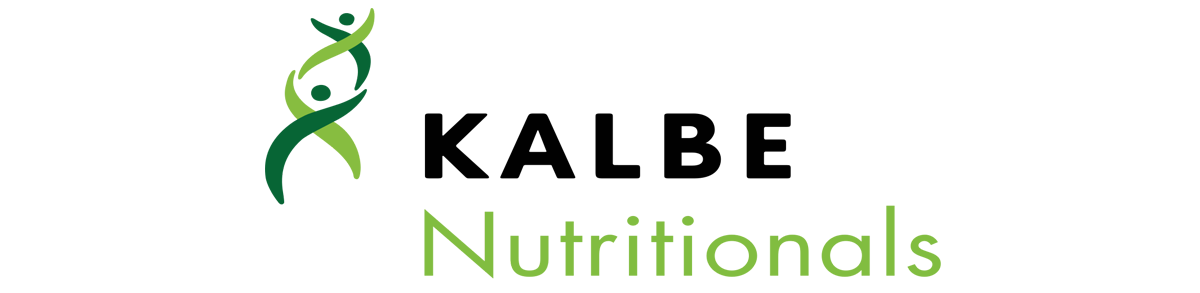

<h1><center>SALES FORECASTING AND CLUSTERING CUSTOMER</center></h1>

<h2><center>Author: Rania Virda Sukmaningsih</center></h2>

# Background

1. **Memprediksi jumlah penjualan (quantity) dari total keseluruhan product Kalbe.**
    - Tujuan: mengetahui perkiraan quantity product yang terjual
    - Prediksi yang dilakukan harus harian. 
2.  **Membuat cluster/segment customer berdasarkan beberapa kriteria.**
    - Tujuan: membuat segment customer.

# Import Library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import preprocessing 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings('ignore')

# Load Dataset

In [2]:
df_customer = pd.read_csv("Case Study - Customer.csv", delimiter=";")
df_product = pd.read_csv("Case Study - Product.csv", delimiter=";")
df_store = pd.read_csv("Case Study - Store.csv", delimiter=";")
df_transaction = pd.read_csv("Case Study - Transaction.csv", delimiter=";")
df_store.head()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,"-6,2","106,816666"
1,2,Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238"
2,3,Prima Kota,Prima,Modern Trade,"-7,797068","110,370529"
3,4,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
4,5,Bonafid,Gita,General Trade,"-7,250445","112,768845"


# Data Cleaning

In [3]:
df_customer.info()
print()
df_product.info()
print()
df_store.info()
print()
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      447 non-null    int64 
 1   Age             447 non-null    int64 
 2   Gender          447 non-null    int64 
 3   Marital Status  444 non-null    object
 4   Income          447 non-null    object
dtypes: int64(3), object(2)
memory usage: 17.6+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductID     10 non-null     object
 1   Product Name  10 non-null     object
 2   Price         10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      ----------

In [4]:
df_customer.head()

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,"5,12"
1,2,60,1,Married,"6,23"
2,3,32,1,Married,"9,17"
3,4,31,1,Married,"4,87"
4,5,58,1,Married,"3,57"


In [5]:
df_product.head()

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200


In [6]:
df_store.head()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,"-6,2","106,816666"
1,2,Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238"
2,3,Prima Kota,Prima,Modern Trade,"-7,797068","110,370529"
3,4,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
4,5,Bonafid,Gita,General Trade,"-7,250445","112,768845"


In [7]:
df_transaction.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4


In [8]:
# change data type

df_customer['Income'] = df_customer['Income'].str.replace(',', '.').astype('float')
df_store['Latitude'] = df_store['Latitude'].str.replace(',', '.').astype('float')
df_store['Longitude'] = df_store['Longitude'].str.replace(',', '.').astype('float')
df_transaction['Date'] = pd.to_datetime(df_transaction['Date'])

In [9]:
df_customer.info()
print()
df_store.info()
print()
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      447 non-null    int64  
 1   Age             447 non-null    int64  
 2   Gender          447 non-null    int64  
 3   Marital Status  444 non-null    object 
 4   Income          447 non-null    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 17.6+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   StoreID     14 non-null     int64  
 1   StoreName   14 non-null     object 
 2   GroupStore  14 non-null     object 
 3   Type        14 non-null     object 
 4   Latitude    14 non-null     float64
 5   Longitude   14 non-null     float64
dtypes: float64(2), int64(1), object(3)
memory usage: 800.0+ bytes

<class 'pandas.core

In [10]:
#check missing values

df_customer.isnull().sum()

CustomerID        0
Age               0
Gender            0
Marital Status    3
Income            0
dtype: int64

In [11]:
df_product.isnull().sum()

ProductID       0
Product Name    0
Price           0
dtype: int64

In [12]:
df_store.isnull().sum()

StoreID       0
StoreName     0
GroupStore    0
Type          0
Latitude      0
Longitude     0
dtype: int64

In [13]:
df_transaction.isnull().sum()

TransactionID    0
CustomerID       0
Date             0
ProductID        0
Price            0
Qty              0
TotalAmount      0
StoreID          0
dtype: int64

In [14]:
# handling missing value

df_customer['Marital Status'].fillna(df_customer['Marital Status'].mode()[0], inplace=True)

In [15]:
df_customer.isnull().sum()

CustomerID        0
Age               0
Gender            0
Marital Status    0
Income            0
dtype: int64

# Merge Data

In [16]:
# merge data
df_merge = pd.merge(df_customer, df_transaction, on = 'CustomerID')
df_merge = pd.merge(df_merge, df_product.drop(columns = 'Price'), on = 'ProductID')
df_merge = pd.merge(df_merge, df_store, on = 'StoreID')
df_merge.head()

,CustomerID,Age,Gender,Marital Status,Income,TransactionID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,1,55,1,Married,5.12,TR54475,2022-02-23,P8,16000,1,16000,9,Oat,Lingga,Lingga,Modern Trade,-3.654703,128.190643
1,5,58,1,Married,3.57,TR53643,2022-05-22,P8,16000,3,48000,9,Oat,Lingga,Lingga,Modern Trade,-3.654703,128.190643
2,7,31,0,Married,4.57,TR5151,2022-10-03,P8,16000,2,32000,9,Oat,Lingga,Lingga,Modern Trade,-3.654703,128.190643
3,19,24,1,Single,4.14,TR98635,2022-06-18,P8,16000,1,16000,9,Oat,Lingga,Lingga,Modern Trade,-3.654703,128.190643
4,28,55,0,Married,6.08,TR9420,2022-12-01,P8,16000,3,48000,9,Oat,Lingga,Lingga,Modern Trade,-3.654703,128.190643


In [17]:
df_merge.isnull().sum()

CustomerID        0
Age               0
Gender            0
Marital Status    0
Income            0
TransactionID     0
Date              0
ProductID         0
Price             0
Qty               0
TotalAmount       0
StoreID           0
Product Name      0
StoreName         0
GroupStore        0
Type              0
Latitude          0
Longitude         0
dtype: int64

# Modelling

## 1. Sales Forecasting Using ARIMA

In [18]:
# model regresi: time series
df_regresi = df_merge.groupby('Date').agg({'Qty':'sum'})
df_regresi.head()

,Qty
Date,
2022-01-01,49
2022-01-02,50
2022-01-03,76
2022-01-04,98
2022-01-05,67


In [19]:
df_regresi.shape

(365, 1)

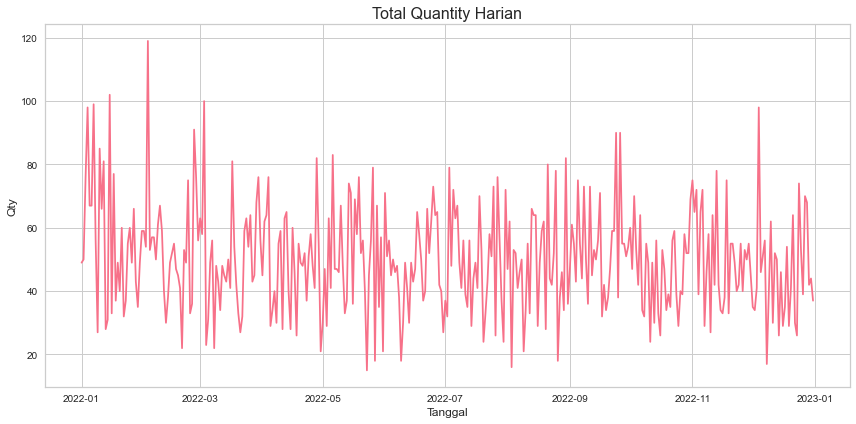

In [20]:
# Visualisasi data time series
# Mengatur palet warna
custom_palette = sns.color_palette("husl")

# Membuat plot
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x='Date', y='Qty', data=df_regresi, color=custom_palette[0])  # Menggunakan warna pertama dari palet
plt.title('Total Quantity Harian', fontsize=16)  # Menambahkan judul
plt.xlabel('Tanggal', fontsize=12)  # Menambahkan label sumbu x
plt.ylabel('Qty', fontsize=12)  # Menambahkan label sumbu y
plt.tight_layout()

# Menampilkan plot
plt.show()

In [21]:
# Splitting the data into training and testing sets
train_size = int(len(df_regresi) * 0.8)  # 80% data for training, 20% for testing
train_data, test_data = df_regresi.iloc[:train_size], df_regresi.iloc[train_size:]

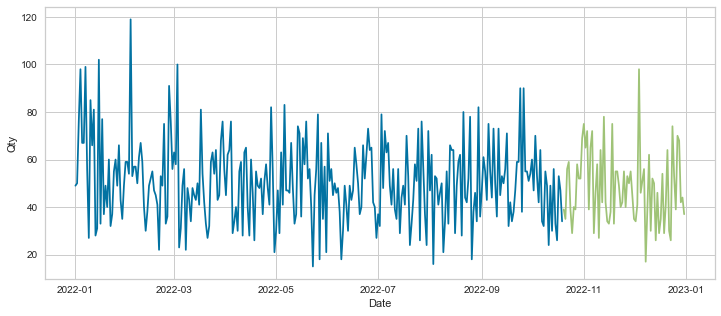

In [22]:
plt.figure(figsize=(12,5))
sns.lineplot(data=train_data, x=train_data.index, y=train_data['Qty'])
sns.lineplot(data=test_data, x=test_data.index, y=test_data['Qty'])
plt.show()

In [23]:
from statsmodels.tsa.stattools import adfuller
def adf_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:", dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
adf_test(df_regresi)

1. ADF :  -19.018782802299725
2. P-Value :  0.0
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression: 364
5. Critical Values :
	 1% :  -3.4484434475193777
	 5% :  -2.869513170510808
	 10% :  -2.571017574266393


Hasil uji _Augmented Dickey-Fuller_ (ADF) adalah sebagai berikut:

ADF Statistic: -19.0187 (Sangat negatif, menunjukkan data stasioner)
p-value: 0.0 (Bukti yang sangat kuat bahwa data adalah stasioner)
Critical Values: Nilai-nilai kritis yang tidak terlampaui oleh ADF Statistic pada semua tingkat signifikansi (1%, 5%, dan 10%).
Kesimpulan: Data yang digunakan adalah stasioner pada semua tingkat signifikansi yang diperiksa.

In [24]:
from statsmodels.tsa.stattools import kpss

# Melakukan uji KPSS pada data time series
kpss_test = kpss(df_regresi['Qty'], regression='c')  # 'c' untuk model dengan komponen konstan (tren)

# Menampilkan hasil uji KPSS
print("Hasil Uji KPSS:")
print("KPSS Statistic:", kpss_test[0])
print("p-value:", kpss_test[1])
print("Tingkat Signifikansi:", kpss_test[3])

# Mengevaluasi hasil uji KPSS
alpha = 0.05  # Tingkat signifikansi yang Anda tentukan (biasanya 0.05)
if kpss_test[1] < alpha:
    print("Kesimpulan: Data memiliki komponen tren (tidak stasioner)")
else:
    print("Kesimpulan: Data adalah stasioner")


Hasil Uji KPSS:
KPSS Statistic: 0.4253522505370782
p-value: 0.06622747821677664
Tingkat Signifikansi: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Kesimpulan: Data adalah stasioner


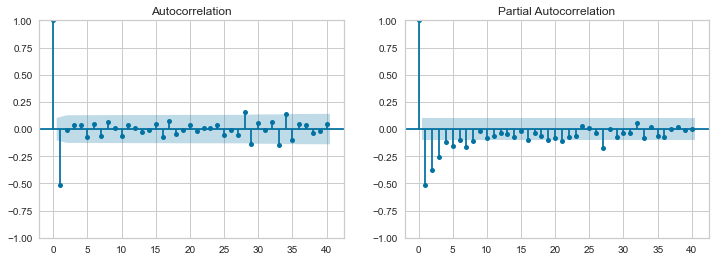

In [25]:
# ACF and PACF plots to determine p and q values
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(df_regresi.diff().dropna(), lags=40, ax=ax[0])
plot_pacf(df_regresi.diff().dropna(), lags=40, ax=ax[1])
plt.show()

In [26]:
import pmdarima as pm

#auto-fit ARIMA
auto_arima = pm.auto_arima(train_data, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

## Hyperparameter Tuning

In [27]:
from itertools import product
# Membuat list untuk p, d, dan q
p = range(0, 6)  # 0-5
d = range(0, 6)  # 0-5
q = range(0, 6)  # 0-5
# Menggunakan fungsi product dari itertools untuk membuat kombinasi p, d, dan q
pdq = list(product(p, d, q))
print(pdq)

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4), (0, 0, 5), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 1, 5), (0, 2, 0), (0, 2, 1), (0, 2, 2), (0, 2, 3), (0, 2, 4), (0, 2, 5), (0, 3, 0), (0, 3, 1), (0, 3, 2), (0, 3, 3), (0, 3, 4), (0, 3, 5), (0, 4, 0), (0, 4, 1), (0, 4, 2), (0, 4, 3), (0, 4, 4), (0, 4, 5), (0, 5, 0), (0, 5, 1), (0, 5, 2), (0, 5, 3), (0, 5, 4), (0, 5, 5), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 0, 3), (1, 0, 4), (1, 0, 5), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 1, 4), (1, 1, 5), (1, 2, 0), (1, 2, 1), (1, 2, 2), (1, 2, 3), (1, 2, 4), (1, 2, 5), (1, 3, 0), (1, 3, 1), (1, 3, 2), (1, 3, 3), (1, 3, 4), (1, 3, 5), (1, 4, 0), (1, 4, 1), (1, 4, 2), (1, 4, 3), (1, 4, 4), (1, 4, 5), (1, 5, 0), (1, 5, 1), (1, 5, 2), (1, 5, 3), (1, 5, 4), (1, 5, 5), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 0, 3), (2, 0, 4), (2, 0, 5), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 1, 3), (2, 1, 4), (2, 1, 5), (2, 2, 0), (2, 2, 1), (2, 2, 2), (2, 2, 3), (2, 2, 4), (2, 2, 5), (2, 3, 0)

In [28]:
from statsmodels.tsa.arima.model import ARIMA
# Membuat list untuk menyimpan Skor AIC
aic_scores = []
# Melakukan grid search manual untuk menemukan p, d, q yang optimal
for param in pdq:
    # Melakukan fitting ARIMA model
    model = ARIMA(df_regresi, order=param)
    model_fit = model.fit()
    # Menambahkan aic score ke list
    aic_scores.append({'par': param, 'aic': model_fit.aic})
    
# Memilih aic score terkecil
best_aic = min(aic_scores, key=lambda x: x['aic'])
print(best_aic)

{'par': (0, 1, 1), 'aic': 3090.5770450743503}


In [29]:
#Hyperparameter tuning
model_hyper = ARIMA(train_data, order=best_aic['par'])
model_fit_hyper = model_hyper.fit()

## Manual

In [30]:
#Trial and error tuning 
model_manual1 = ARIMA(train_data, order=(40,1,1))
model_fit_manual1 = model_manual1.fit()

In [31]:
#Trial and error tuning 
model_manual2 = ARIMA(train_data, order=(40,1,2))
model_fit_manual2 = model_manual2.fit()

In [32]:
#Trial and error tuning 
model_manual3 = ARIMA(train_data, order=(40,2,1))
model_fit_manual3 = model_manual3.fit()

In [33]:
#Trial and error tuning 
model_manual4 = ARIMA(train_data, order=(40,2,2))
model_fit_manual4 = model_manual4.fit()

## Ploting Forecasting

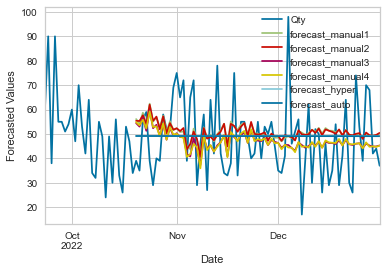

In [34]:
#plot forecasting
forecast_manual1 = model_fit_manual1.forecast(len(test_data))
forecast_manual2 = model_fit_manual2.forecast(len(test_data))
forecast_manual3 = model_fit_manual3.forecast(len(test_data))
forecast_manual4 = model_fit_manual4.forecast(len(test_data))
forecast_hyper = model_fit_hyper.forecast(len(test_data))
forecast_auto = auto_arima.predict(len(test_data))

df_plot = df_regresi.iloc[-100:]

df_plot['forecast_manual1'] = [None]*(len(df_plot)-len(forecast_manual1)) + list(forecast_manual1)
df_plot['forecast_manual2'] = [None]*(len(df_plot)-len(forecast_manual2)) + list(forecast_manual2)
df_plot['forecast_manual3'] = [None]*(len(df_plot)-len(forecast_manual3)) + list(forecast_manual3)
df_plot['forecast_manual4'] = [None]*(len(df_plot)-len(forecast_manual4)) + list(forecast_manual4)
df_plot['forecast_hyper'] = [None]*(len(df_plot)-len(forecast_hyper)) + list(forecast_hyper)
df_plot['forecast_auto'] = [None]*(len(df_plot)-len(forecast_auto)) + list(forecast_auto)

df_plot.plot()

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Forecasted Values')
plt.legend()

plt.show()

## Metrics Evaluation

In [35]:
#Manual parameter tuning metrics

mae1 = mean_absolute_error(test_data, forecast_manual1)
mape1 = mean_absolute_percentage_error(test_data, forecast_manual1)
rmse1 = np.sqrt(mean_squared_error(test_data, forecast_manual1))

print(f'mae - manual: {round(mae1,4)}')
print(f'mape - manual: {round(mape1,4)}')
print(f'rmse - manual: {round(rmse1,4)}')

mae - manual: 12.8352
mape - manual: 0.3174
rmse - manual: 15.8303


In [36]:
mae2 = mean_absolute_error(test_data, forecast_manual2)
mape2 = mean_absolute_percentage_error(test_data, forecast_manual2)
rmse2 = np.sqrt(mean_squared_error(test_data, forecast_manual2))

print(f'mae - manual: {round(mae2,4)}')
print(f'mape - manual: {round(mape2,4)}')
print(f'rmse - manual: {round(rmse2,4)}')

mae - manual: 12.7654
mape - manual: 0.3156
rmse - manual: 15.7329


In [37]:
mae3 = mean_absolute_error(test_data, forecast_manual3)
mape3 = mean_absolute_percentage_error(test_data, forecast_manual3)
rmse3 = np.sqrt(mean_squared_error(test_data, forecast_manual3))

print(f'mae - manual: {round(mae3,4)}')
print(f'mape - manual: {round(mape3,4)}')
print(f'rmse - manual: {round(rmse3,4)}')

mae - manual: 12.3571
mape - manual: 0.2837
rmse - manual: 15.4724


In [38]:
mae4 = mean_absolute_error(test_data, forecast_manual4)
mape4 = mean_absolute_percentage_error(test_data, forecast_manual4)
rmse4 = np.sqrt(mean_squared_error(test_data, forecast_manual4))

print(f'mae - manual: {round(mae4,4)}')
print(f'mape - manual: {round(mape4,4)}')
print(f'rmse - manual: {round(rmse4,4)}')

mae - manual: 12.3553
mape - manual: 0.2835
rmse - manual: 15.5705


In [39]:
#Hyperparameter tuning metrics

mae = mean_absolute_error(test_data, forecast_hyper)
mape = mean_absolute_percentage_error(test_data, forecast_hyper)
rmse = np.sqrt(mean_squared_error(test_data, forecast_hyper))

print(f'mae - hyper: {round(mae,4)}')
print(f'mape - hyper: {round(mape,4)}')
print(f'rmse - hyper: {round(rmse,4)}')

mae - hyper: 12.6501
mape - hyper: 0.304
rmse - hyper: 15.3376


In [40]:
#Auto-fit ARIMA metrics

mae = mean_absolute_error(test_data, forecast_auto)
mape = mean_absolute_percentage_error(test_data, forecast_auto)
rmse = np.sqrt(mean_squared_error(test_data, forecast_auto))

print(f'mae - auto: {round(mae,4)}')
print(f'mape - auto: {round(mape,4)}')
print(f'rmse - auto: {round(rmse,4)}')

mae - auto: 12.6409
mape - auto: 0.3034
rmse - auto: 15.33


Manual Hyperparameter Tuning with order (40,2,2) shows the best evaluation metrics

## Forecast Quantity

In [41]:
#Apply model to forecast data
model = ARIMA(df_regresi, order=(40, 2, 2))
model_fit = model.fit()
forecast = model_fit.forecast(steps=31)

In [42]:
# Assuming 'forecast' contains your forecasted values
forecast_df = pd.DataFrame({'Forecast Qty': forecast})

# Optionally, you can set the index to represent the dates for the forecasted period if applicable.
# For example, if you want to set the index starting from the next day after your existing data:
forecast_start_date = df_regresi.index[-1] + pd.DateOffset(days=1)
forecast_dates = pd.date_range(forecast_start_date, periods=len(forecast), freq='D')
forecast_df.index = forecast_dates

# Print the DataFrame
forecast_df.head()

,Forecast Qty
2023-01-01,55.501091
2023-01-02,46.128586
2023-01-03,48.190891
2023-01-04,51.437136
2023-01-05,44.279847


In [43]:
# Forecast
forecast_steps = 31  # Adjust as needed
forecast = model_fit.get_forecast(steps=forecast_steps)

# Get lower and upper confidence intervals
forecast_ci = forecast.conf_int()

# Create a DataFrame for the forecasted values, lower, and upper bounds
forecast_df = pd.DataFrame({
    'Forecast Qty': forecast.predicted_mean.round(4),  # Round to 4 decimal places
    'Lower Qty': forecast_ci['lower Qty'].round(4), 
    'Upper Qty': forecast_ci['upper Qty'].round(4), 
})

# Optionally, set the index to represent the dates for the forecasted period if applicable.
# For example, if you want to set the index starting from the next day after your existing data:
forecast_start_date = df_regresi.index[-1] + pd.DateOffset(days=1)
forecast_dates = pd.date_range(forecast_start_date, periods=forecast_steps, freq='D')
forecast_df.index = forecast_dates

# Print the DataFrame
forecast_df.head(31)

,Forecast Qty,Lower Qty,Upper Qty
2023-01-01,55.5011,24.2800,86.7222
2023-01-02,46.1286,14.9018,77.3553
2023-01-03,48.1909,16.9271,79.4547
2023-01-04,51.4371,19.9778,82.8965
2023-01-05,44.2798,12.7088,75.8509
2023-01-06,35.7190,4.1473,67.2907
2023-01-07,46.2713,14.6886,77.8540
2023-01-08,36.6894,5.0955,68.2834
2023-01-09,44.6749,12.9737,76.3761
2023-01-10,53.1087,21.3929,84.8246


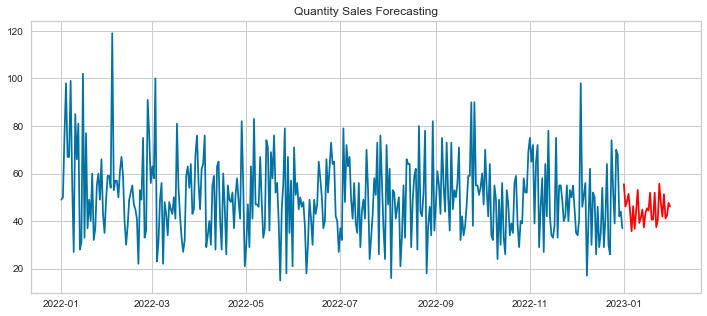

In [44]:
#Plot forecasting
plt.figure(figsize=(12,5))
plt.plot(df_regresi)
plt.plot(forecast_df['Forecast Qty'],color='red')
plt.title('Quantity Sales Forecasting')
plt.show()

In [45]:
forecast_df.describe()

,Forecast Qty,Lower Qty,Upper Qty
count,31.000000,31.000000,31.000000
mean,44.990145,13.047413,76.932906
std,5.497343,5.526130,5.514039
min,35.719000,4.147300,67.290700
25%,40.904350,8.759150,72.889950
50%,44.674900,12.901500,76.376100
75%,47.915450,16.011200,80.277550
max,55.728900,24.280000,88.038200


Berdasarkan prediksi jumlah penjualan harian, rata-rata penjualan dibulan Januari 2023 adalah 44,99 atau sekitar 45 pcs/hari.

## Clustering Customer Using KMeans

In [18]:
df_merge.head()

,CustomerID,Age,Gender,Marital Status,Income,TransactionID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,1,55,1,Married,5.12,TR54475,2022-02-23,P8,16000,1,16000,9,Oat,Lingga,Lingga,Modern Trade,-3.654703,128.190643
1,5,58,1,Married,3.57,TR53643,2022-05-22,P8,16000,3,48000,9,Oat,Lingga,Lingga,Modern Trade,-3.654703,128.190643
2,7,31,0,Married,4.57,TR5151,2022-10-03,P8,16000,2,32000,9,Oat,Lingga,Lingga,Modern Trade,-3.654703,128.190643
3,19,24,1,Single,4.14,TR98635,2022-06-18,P8,16000,1,16000,9,Oat,Lingga,Lingga,Modern Trade,-3.654703,128.190643
4,28,55,0,Married,6.08,TR9420,2022-12-01,P8,16000,3,48000,9,Oat,Lingga,Lingga,Modern Trade,-3.654703,128.190643


In [19]:
df_clus = df_merge.groupby('CustomerID').agg({'TransactionID':'count',
                                                   'Qty':'sum',
                                                   'TotalAmount':'sum'}).reset_index()
df_clus

,CustomerID,TransactionID,Qty,TotalAmount
0,1,17,60,623300
1,2,13,57,392300
2,3,15,56,446200
3,4,10,46,302500
4,5,7,27,268600
...,...,...,...,...
442,443,16,59,485100
443,444,18,62,577700
444,445,18,68,587200
445,446,11,42,423300


In [20]:
df_clus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   CustomerID     447 non-null    int64
 1   TransactionID  447 non-null    int64
 2   Qty            447 non-null    int64
 3   TotalAmount    447 non-null    int64
dtypes: int64(4)
memory usage: 14.1 KB


In [21]:
df_cluster = df_clus.drop(columns = ['CustomerID'])
df_cluster.head()

,TransactionID,Qty,TotalAmount
0,17,60,623300
1,13,57,392300
2,15,56,446200
3,10,46,302500
4,7,27,268600


## Check Missing Values

In [22]:
df_cluster.isna().sum()

TransactionID    0
Qty              0
TotalAmount      0
dtype: int64

In [23]:
#Standarisasi dataset
X = df_cluster.values
X_std = StandardScaler().fit_transform(X)
df_std = pd.DataFrame(data=X_std,columns=df_cluster.columns)

In [24]:
#Normalisasi dataset dengan minmaxscaler
X_norm = MinMaxScaler().fit_transform(X)

In [25]:
wcss= []
for n in range (1,11):
    model1 = KMeans(n_clusters=n, init='k-means++', n_init = 10, max_iter=100, tol =0.0001, random_state = 100)
    model1.fit(X_std)
    wcss.append(model1.inertia_)
print(wcss)

[1341.0000000000002, 543.2539723846328, 316.9717123222516, 238.5531321641924, 192.16713152981617, 169.7845616020577, 153.8492948432472, 141.49693998928464, 129.99813774709875, 122.54043730511752]


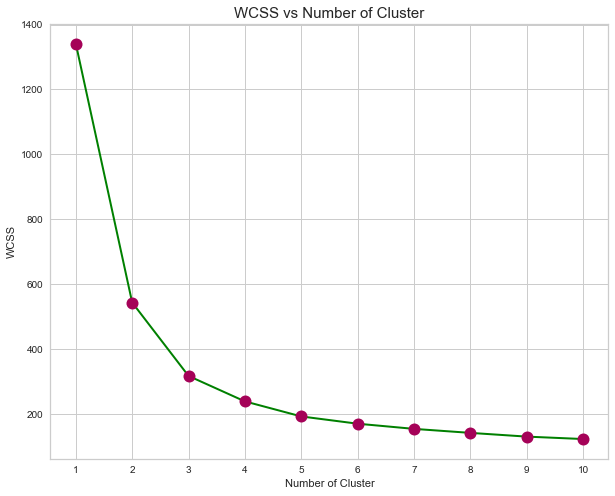

In [26]:
plt.figure(figsize=(10,8))
plt.plot(list(range(1,11)), wcss, color = 'green', marker = 'o', linewidth=2, markersize=12, markerfacecolor= 'm', 
         markeredgecolor= 'm')
plt.title('WCSS vs Number of Cluster', fontsize = 15)
plt.xlabel('Number of Cluster')
plt.ylabel('WCSS')
plt.xticks(list(range(1,11)))
plt.show()

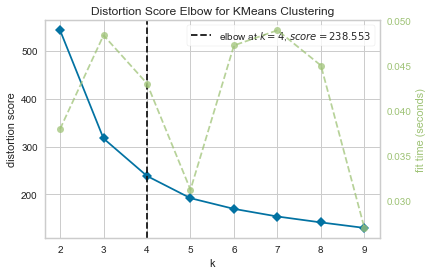

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [27]:
#Elbow Method with yellowbrick library
visualizer = KElbowVisualizer(model1, k=(2,10))
visualizer.fit(X_std)
visualizer.show()

In [28]:
K = range(2,8)
fits=[]
score=[]

for k in K:
    model = KMeans(n_clusters = k, random_state = 0, n_init= 'auto').fit(X_std)
    fits.append(model)
    score.append(silhouette_score(X_std, model.labels_, metric='euclidean'))

<AxesSubplot:>

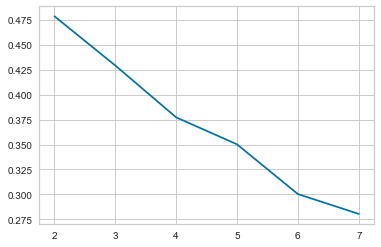

In [29]:

sns.lineplot(x = K, y = score)

Cluster terbaik yaitu 5 cluster

In [30]:
# Kmeans n_cluster = 4
#Clustering Kmeans
kmeans_4 = KMeans(n_clusters=4,init='k-means++',max_iter=300,n_init=10,random_state=42)
kmeans_4.fit(X_std)

KMeans(n_clusters=4, n_init=10, random_state=42)

In [31]:
# Masukin cluster ke dataset
df_cluster['cluster'] = kmeans_4.labels_
df_cluster.head()

,TransactionID,Qty,TotalAmount,cluster
0,17,60,623300,3
1,13,57,392300,0
2,15,56,446200,0
3,10,46,302500,2
4,7,27,268600,1


In [32]:
df_cluster['cluster'].value_counts()

2    180
0    114
1     93
3     60
Name: cluster, dtype: int64

<Figure size 432x432 with 0 Axes>

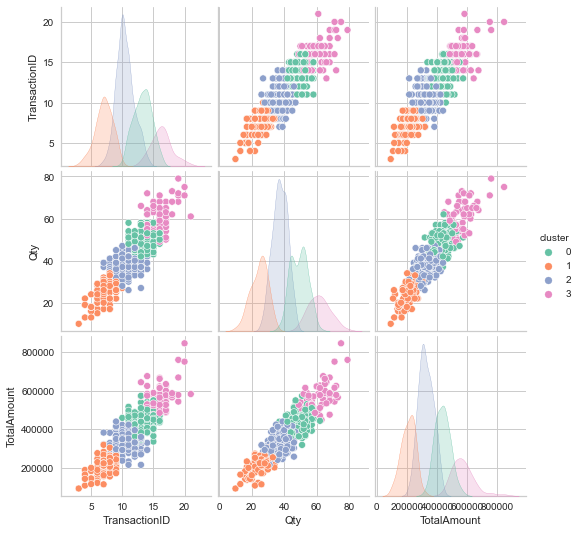

In [33]:
plt.figure(figsize=(6,6))
sns.pairplot(data=df_cluster,hue='cluster',palette='Set2')
plt.show()

## Customer Personality Analysis

In [34]:
df_cluster['cluster'] = kmeans_4.labels_
df_cluster.groupby('cluster').agg(['count','mean', 'median', 'std'])

TransactionID                               Qty                    \
                count       mean median       std count       mean median   
cluster                                                                     
0                 114  13.254386   13.0  1.413033   114  49.078947   50.0   
1                  93   7.021505    7.0  1.398590    93  24.505376   25.0   
2                 180  10.427778   10.0  1.382373   180  37.350000   37.0   
3                  60  16.316667   16.0  1.682328    60  61.650000   61.5   

                  TotalAmount                                         
              std       count           mean    median           std  
cluster                                                               
0        5.183611         114  436203.508772  438800.0  49773.637920  
1        5.201638          93  208283.870968  211000.0  46253.056986  
2        4.587419         180  325663.333333  319700.0  48411.042533  
3        6.589218          60  572100.000000  565200.0  73705.899771

In [35]:
df_cluster.describe().T

,count,mean,std,min,25%,50%,75%,max
TransactionID,447.0,11.230425,3.245302,3.0,9.0,11.0,14.0,21.0
Qty,447.0,40.930649,12.756679,10.0,32.0,40.0,50.0,79.0
TotalAmount,447.0,362512.304251,124634.279184,92100.0,271750.0,354200.0,441200.0,846700.0
cluster,447.0,1.416107,1.011818,0.0,0.0,2.0,2.0,3.0


In [36]:
# percentage of customers per cluster
cluster_count = df_cluster['cluster'].value_counts().reset_index()
cluster_count.columns = ['cluster', 'count']
cluster_count['percentage (%)'] = round((cluster_count['count']/len(df_cluster))*100,2)
cluster_count = cluster_count.sort_values(by = ['cluster']).reset_index(drop = True)
cluster_count

,cluster,count,percentage (%)
0,0,114,25.50
1,1,93,20.81
2,2,180,40.27
3,3,60,13.42


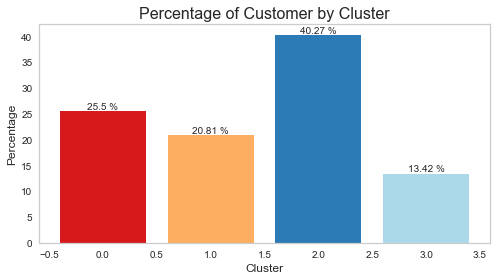

In [37]:
# visualization of the percentage of customers in each cluster
fig, ax = plt.subplots(figsize = (7,4))

c = ["#d7191c","#fdae61","#2c7bb6","#abd9e9", "#ffffbf"]

bars = plt.bar(x = cluster_count['cluster'],
               height = cluster_count['percentage (%)'],
               color = c)

for bar in bars:
  height = bar.get_height()
  label_x_pos = bar.get_x() + bar.get_width() / 2
  ax.text(label_x_pos, height, s = f'{height} %', ha='center',
  va = 'bottom')

plt.title('Percentage of Customer by Cluster', fontsize = 16)
plt.xlabel('Cluster',fontsize = 12)
plt.ylabel('Percentage',fontsize = 12)
plt.style.use('tableau-colorblind10')
plt.grid(False)
plt.tight_layout()

In [38]:
# Hitung agregasi
agg_result = df_cluster.groupby('cluster').agg(['min', 'max', 'mean'])

# Bulatkan hasil agregasi menjadi dua angka desimal
agg_result = agg_result.round(2)

# Reset indeks dan tampilkan hasilnya
agg_result.reset_index(drop=True).T

0          1          2          3
TransactionID min       10.00       3.00       7.00      13.00
              max       16.00      10.00      14.00      21.00
              mean      13.25       7.02      10.43      16.32
Qty           min       37.00      10.00      26.00      49.00
              max       62.00      34.00      47.00      79.00
              mean      49.08      24.51      37.35      61.65
TotalAmount   min   318600.00   92100.00  215100.00  448900.00
              max   574000.00  319200.00  440200.00  846700.00
              mean  436203.51  208283.87  325663.33  572100.00

In [55]:
# Menghitung mean dan count untuk setiap cluster
df_cluster_mean = df_cluster.groupby('cluster').agg({
    'TransactionID': 'mean',  # Menghitung jumlah observasi dalam setiap cluster
    'Qty': 'mean',  # Menghitung rata-rata Qty dalam setiap cluster
    'TotalAmount': 'mean'  # Menghitung rata-rata TotalAmount dalam setiap cluster
}).reset_index()  # Mereset indeks sehingga cluster menjadi kolom biasa

# Menambahkan kolom 'Count' berisi jumlah penghitungan setiap cluster
df_cluster_mean['Count'] = df_cluster['cluster'].value_counts().values

# Mengganti nama kolom "Count" menjadi "Total_Customer"
df_cluster_mean = df_cluster_mean.rename(columns={'Count': 'TotalCustomer'})

# Menyortir DataFrame berdasarkan jumlah penghitungan (Count) dalam urutan menurun
df_cluster_mean = df_cluster_mean.sort_values(['TotalAmount', 'TransactionID', 'Qty'], ascending=False)

df_cluster_mean = df_cluster_mean.round(2)

In [56]:
df_cluster_mean.reset_index(drop=True)

,cluster,TransactionID,Qty,TotalAmount,TotalCustomer
0,3,16.32,61.65,572100.00,60
1,0,13.25,49.08,436203.51,180
2,2,10.43,37.35,325663.33,93
3,1,7.02,24.51,208283.87,114


## Clustering Interpretation

1. **Cluster 0 - Loyal Customer**
    - Terdapat 114 customer (25,5%).
    - Pelanggan dikelompok ini adalah pelanggan yang melakukan transaksi dengan jumlah dan total belanja yang tinggi, yaitu:
    </p>a) rata-rata transaksi sekitar 13 kali transaksi, 
    </p>b) rata-rata jumlah atau kuantitas produk yang dibeli sekitar 49 unit produk, dan 
    </p>c) rata-rata jumlah uang yang dikeluarkan oleh pelanggan tipe ini sekitar 436K.
</p>
2. **Cluster 1 - New Customer**
    - Terdapat 93 customer (20,81%)
    - Customer di kelompok ini adalah pelanggan yang melakukan transaksi dengan jumlah dan total belanja paling rendah, yaitu:
    </p>a) rata-rata transaksi sekitar 7 kali transaksi, 
    </p>b) rata-rata jumlah atau kuantitas produk yang dibeli sekitar 24 unit produk, dan 
    </p>c) rata-rata jumlah uang yang dikeluarkan oleh pelanggan tipe ini sekitar 208K.
</p>
3. **Cluster 2 - Regular Customer**
    - Terdapat 180 customer (40,27%)
    - Customer di kelompok ini adalah pelanggan yang melakukan transaksi dengan jumlah dan total belanja yang stabil dan sedang, yaitu:    
    </p>a) rata-rata transaksi sekitar 10 kali transaksi, 
    </p>b) rata-rata jumlah atau kuantitas produk yang dibeli sekitar 37 unit produk, dan 
    </p>c) rata-rata jumlah uang yang dikeluarkan oleh pelanggan tipe ini sekitar 326K.
</p>
4. **Cluster 3 - VIP Customer**
    - Terdapat 60 customer (13,42%)
    - Customer di kelompok ini adalah pelanggan yang melakukan transaksi yang tinggi dengan jumlah belanja yang besar, dan total belanja yang tinggi, yaitu:    
    </p>a) rata-rata transaksi sekitar 16 kali transaksi, 
    </p>b) rata-rata jumlah atau kuantitas produk yang dibeli sekitar 61 unit produk, dan 
    </p>c) rata-rata jumlah uang yang dikeluarkan oleh pelanggan tipe ini sekitar 572K.

## Rekomendasi Bisnis

1. **Cluster 0 - Loyal Customer**
    - **Cross-Selling Produk Terkait:** Pelanggan setia dapat diberikan penawaran khusus, seperti "Beli 3 Paket Cheese Sticks, Dapatkan 1 Paket Choco Bars dengan Diskon 15%."
    - **Promosi Berbasis Musim:** Selama perayaan hari besar, perusahaan dapat memberikan diskon eksklusif pada produk-produk favorit pelanggan setia mereka, seperti "Hemat 15% untuk Pembelian Cheese Sticks selama Natal."
    - **Program Diskon Kelipatan:** Jika pelanggan setia mencapai 10 transaksi, perusahaan dapat memberikan diskon 10% ekstra pada pembelian berikutnya dengan syarat dan ketentuan tertentu.
</p>

2. **Cluster 1 - New Customer** 
    - **Paket Hemat**: Ketika pelanggan baru pertama kali berbelanja, mereka dapat membeli "Paket Selamat Datang" yang berisi tiga produk dengan penjualan tertinggi dengan harga yang lebih murah dari total harga individu produk.
    - **Program Referral:** Berikan diskon 20% pada pembelian berikutnya kepada pelanggan baru jika mereka merujuk teman atau keluarga yang melakukan pembelian pertama kali.
    - **Cross-Selling Produk Terkait:** Ketika pelanggan baru membeli salah satu dari tiga produk dengan penjualan tertinggi, tawarkan tambahan "satu produk terendah dengan Diskon 20%" sebagai produk terkait.
</p>

3. **Cluster 2 - Regular Customer**
    - **Cross-Selling Produk Terkait:** Ketika pelanggan reguler membeli salah satu dari 5 produk dengan penjualan tertinggi, tawarkan diskon 10% untuk pembelian salah satu produk yang sering dibeli bersamaan.
    - **Promosi Berbasis Musim:** Selama perayaan hari besar, tawarkan "Paket Hemat" yang berisi 2 produk dengan penjualan tertinggi dan 1 produk dengan penjualan terendah dengan diskon tertentu.
    - **Program Diskon Kelipatan:** Berikan diskon tambahan 5% jika pelanggan reguler mencapai jumlah transaksi kesepuluh dalam satu bulan.
</p>

4. **Cluster 3 - VIP Customer**
    - **Cross-Selling Produk Terkait:** Pelanggan VIP yang membeli salah satu dari 3 produk dengan penjualan terendah dapat diberikan penawaran eksklusif, seperti "Dapatkan Diskon 25% untuk Pembelian salah satu produk dengan penjualan tertinggi."
    - **Program Diskon Kelipatan:** Jika pelanggan VIP mencapai total belanja tertentu dalam satu tahun, berikan diskon 15% pada pembelian selanjutnya.
    - **Promosi Berbasis Musim:** Selama musim liburan, tawarkan produk Thai Tea premium yang eksklusif untuk pelanggan VIP.